In [ ]:
import os
import torch
import albumentations
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from torchmetrics.classification import BinaryJaccardIndex
from PascalVOC_Dataset import PascalVOC_Dataset
from pathlib import Path

In [ ]:
dataset_path = Path(__file__).parent / ".." / "dataset" / "VOC2012_train_val" / "VOC2012_train_val"
text_path = dataset_path / "ImageSets" / "Segmentation" / "trainval.txt"
with open(text_path, "r") as f:
    image_ids = f.read().splitlines()
    print(image_ids)

image_directory= dataset_path / "JPEGImages"
mask_directory = dataset_path / "SegmentationClass"

image_paths = [image_directory / f"{img_id}.jpg" for img_id in image_ids]
mask_paths = [mask_directory/f"{img_id}.png" for img_id in image_ids]

print(f"Images: {len(image_paths)}")
print(f"Masks: {len(mask_paths)}")


Images: 2913
Masks: 2913


In [7]:
train_transform = albumentations.Compose([
    albumentations.Resize(256, 256),
    albumentations.Rotate(limit=35, p=1.0),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.1),
    albumentations.Normalize(),
    ToTensorV2(),
])


In [ ]:
train_dataset = PascalVOC_Dataset(
    image_paths=image_paths,
    mask_paths=mask_paths,
    transform=train_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=10,
    pin_memory=True
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()
iou_metric = BinaryJaccardIndex().to(device)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=3
)


In [ ]:
NUM_EPOCHS = 50
best_iou = 0.0

train_losses = []
train_ious = []

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0
    epoch_iou = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{NUM_EPOCHS}]")

    for images, masks in progress_bar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()
        targets = masks.int()

        iou = iou_metric(preds, targets)

        epoch_loss += loss.item()
        epoch_iou += iou.item()

        progress_bar.set_postfix(
            loss=loss.item(),
            iou=iou.item()
        )

    avg_loss = epoch_loss / len(train_loader)
    avg_iou = epoch_iou / len(train_loader)

    train_losses.append(avg_loss)
    train_ious.append(avg_iou)

    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | IoU: {avg_iou:.4f}")

    scheduler.step(avg_iou)

    # Save the best model
    if avg_iou > best_iou:
        best_iou = avg_iou
        torch.save(model.state_dict(), "best_unet_iou.pth")
        print(f"✅ Best model saved (IoU={best_iou:.4f})")


Epoch [1/50]: 100%|██████████| 365/365 [00:48<00:00,  7.46it/s, iou=0.0857, loss=0.478]


Epoch 1 | Loss: 0.3625 | IoU: 0.5758
✅ Best model saved (IoU=0.5758)


Epoch [2/50]: 100%|██████████| 365/365 [00:44<00:00,  8.17it/s, iou=0.938, loss=0.114]


Epoch 2 | Loss: 0.2821 | IoU: 0.6575
✅ Best model saved (IoU=0.6575)


Epoch [3/50]: 100%|██████████| 365/365 [00:45<00:00,  8.04it/s, iou=0.737, loss=0.192]


Epoch 3 | Loss: 0.2636 | IoU: 0.6734
✅ Best model saved (IoU=0.6734)


Epoch [4/50]: 100%|██████████| 365/365 [00:45<00:00,  7.98it/s, iou=0.521, loss=0.528]


Epoch 4 | Loss: 0.2484 | IoU: 0.6949
✅ Best model saved (IoU=0.6949)


Epoch [5/50]: 100%|██████████| 365/365 [00:46<00:00,  7.85it/s, iou=0.418, loss=1.25]


Epoch 5 | Loss: 0.2318 | IoU: 0.7125
✅ Best model saved (IoU=0.7125)


Epoch [6/50]: 100%|██████████| 365/365 [00:47<00:00,  7.75it/s, iou=0.637, loss=0.437]


Epoch 6 | Loss: 0.2322 | IoU: 0.7153
✅ Best model saved (IoU=0.7153)


Epoch [7/50]: 100%|██████████| 365/365 [00:46<00:00,  7.81it/s, iou=0.741, loss=0.11]


Epoch 7 | Loss: 0.2122 | IoU: 0.7357
✅ Best model saved (IoU=0.7357)


Epoch [8/50]: 100%|██████████| 365/365 [00:46<00:00,  7.84it/s, iou=0.531, loss=0.215]


Epoch 8 | Loss: 0.2066 | IoU: 0.7421
✅ Best model saved (IoU=0.7421)


Epoch [9/50]: 100%|██████████| 365/365 [00:47<00:00,  7.71it/s, iou=0.887, loss=0.125]


Epoch 9 | Loss: 0.1966 | IoU: 0.7534
✅ Best model saved (IoU=0.7534)


Epoch [10/50]: 100%|██████████| 365/365 [00:46<00:00,  7.81it/s, iou=0.892, loss=0.108]


Epoch 10 | Loss: 0.1866 | IoU: 0.7656
✅ Best model saved (IoU=0.7656)


Epoch [11/50]: 100%|██████████| 365/365 [00:46<00:00,  7.85it/s, iou=0.604, loss=1.28]


Epoch 11 | Loss: 0.1846 | IoU: 0.7699
✅ Best model saved (IoU=0.7699)


Epoch [12/50]: 100%|██████████| 365/365 [00:46<00:00,  7.79it/s, iou=0.949, loss=0.0665]


Epoch 12 | Loss: 0.1767 | IoU: 0.7787
✅ Best model saved (IoU=0.7787)


Epoch [13/50]: 100%|██████████| 365/365 [00:46<00:00,  7.84it/s, iou=0.591, loss=0.493]


Epoch 13 | Loss: 0.1726 | IoU: 0.7823
✅ Best model saved (IoU=0.7823)


Epoch [14/50]: 100%|██████████| 365/365 [00:46<00:00,  7.82it/s, iou=0.489, loss=0.573]


Epoch 14 | Loss: 0.1733 | IoU: 0.7799


Epoch [15/50]: 100%|██████████| 365/365 [00:47<00:00,  7.74it/s, iou=0.833, loss=0.108]


Epoch 15 | Loss: 0.1635 | IoU: 0.7921
✅ Best model saved (IoU=0.7921)


Epoch [16/50]: 100%|██████████| 365/365 [00:46<00:00,  7.84it/s, iou=0.875, loss=0.0913]


Epoch 16 | Loss: 0.1621 | IoU: 0.7946
✅ Best model saved (IoU=0.7946)


Epoch [17/50]: 100%|██████████| 365/365 [00:46<00:00,  7.85it/s, iou=0.72, loss=0.314]


Epoch 17 | Loss: 0.1586 | IoU: 0.8004
✅ Best model saved (IoU=0.8004)


Epoch [18/50]: 100%|██████████| 365/365 [00:46<00:00,  7.79it/s, iou=0.425, loss=0.184]


Epoch 18 | Loss: 0.1574 | IoU: 0.7978


Epoch [19/50]: 100%|██████████| 365/365 [00:46<00:00,  7.84it/s, iou=0.935, loss=0.0549]


Epoch 19 | Loss: 0.1489 | IoU: 0.8080
✅ Best model saved (IoU=0.8080)


Epoch [20/50]: 100%|██████████| 365/365 [00:46<00:00,  7.85it/s, iou=0.0659, loss=1.29]


Epoch 20 | Loss: 0.1487 | IoU: 0.8125
✅ Best model saved (IoU=0.8125)


Epoch [21/50]: 100%|██████████| 365/365 [00:47<00:00,  7.74it/s, iou=0.838, loss=0.226]


Epoch 21 | Loss: 0.1502 | IoU: 0.8091


Epoch [22/50]: 100%|██████████| 365/365 [00:46<00:00,  7.83it/s, iou=0.977, loss=0.059]


Epoch 22 | Loss: 0.1509 | IoU: 0.8072


Epoch [23/50]: 100%|██████████| 365/365 [00:46<00:00,  7.84it/s, iou=0.921, loss=0.196]


Epoch 23 | Loss: 0.1445 | IoU: 0.8160
✅ Best model saved (IoU=0.8160)


Epoch [24/50]: 100%|██████████| 365/365 [00:47<00:00,  7.69it/s, iou=0.813, loss=0.163]


Epoch 24 | Loss: 0.1381 | IoU: 0.8239
✅ Best model saved (IoU=0.8239)


Epoch [25/50]: 100%|██████████| 365/365 [00:46<00:00,  7.83it/s, iou=0.803, loss=0.227]


Epoch 25 | Loss: 0.1456 | IoU: 0.8146


Epoch [26/50]: 100%|██████████| 365/365 [00:46<00:00,  7.86it/s, iou=0.586, loss=0.447]


Epoch 26 | Loss: 0.1391 | IoU: 0.8219


Epoch [27/50]: 100%|██████████| 365/365 [00:47<00:00,  7.72it/s, iou=0.595, loss=0.267]


Epoch 27 | Loss: 0.1463 | IoU: 0.8127


Epoch [28/50]: 100%|██████████| 365/365 [00:46<00:00,  7.80it/s, iou=0.51, loss=0.151]


Epoch 28 | Loss: 0.1294 | IoU: 0.8322
✅ Best model saved (IoU=0.8322)


Epoch [29/50]: 100%|██████████| 365/365 [00:46<00:00,  7.87it/s, iou=0.823, loss=0.163]


Epoch 29 | Loss: 0.1277 | IoU: 0.8364
✅ Best model saved (IoU=0.8364)


Epoch [30/50]: 100%|██████████| 365/365 [00:47<00:00,  7.71it/s, iou=0.223, loss=3.41]


Epoch 30 | Loss: 0.1396 | IoU: 0.8320


Epoch [31/50]: 100%|██████████| 365/365 [00:46<00:00,  7.84it/s, iou=0.931, loss=0.0306]


Epoch 31 | Loss: 0.1330 | IoU: 0.8292


Epoch [32/50]: 100%|██████████| 365/365 [00:46<00:00,  7.84it/s, iou=0.844, loss=0.212]


Epoch 32 | Loss: 0.1331 | IoU: 0.8291


Epoch [33/50]: 100%|██████████| 365/365 [00:46<00:00,  7.79it/s, iou=0.327, loss=0.176]


Epoch 33 | Loss: 0.1277 | IoU: 0.8313


Epoch [34/50]: 100%|██████████| 365/365 [00:46<00:00,  7.81it/s, iou=0.847, loss=0.128]


Epoch 34 | Loss: 0.1167 | IoU: 0.8482
✅ Best model saved (IoU=0.8482)


Epoch [35/50]: 100%|██████████| 365/365 [00:46<00:00,  7.81it/s, iou=0.909, loss=0.162]


Epoch 35 | Loss: 0.1048 | IoU: 0.8626
✅ Best model saved (IoU=0.8626)


Epoch [36/50]: 100%|██████████| 365/365 [00:46<00:00,  7.80it/s, iou=0.808, loss=0.0643]


Epoch 36 | Loss: 0.1028 | IoU: 0.8665
✅ Best model saved (IoU=0.8665)


Epoch [37/50]: 100%|██████████| 365/365 [00:47<00:00,  7.75it/s, iou=0.867, loss=0.0788]


Epoch 37 | Loss: 0.1010 | IoU: 0.8665
✅ Best model saved (IoU=0.8665)


Epoch [38/50]: 100%|██████████| 365/365 [00:46<00:00,  7.79it/s, iou=0.905, loss=0.034]


Epoch 38 | Loss: 0.1022 | IoU: 0.8652


Epoch [39/50]: 100%|██████████| 365/365 [00:46<00:00,  7.81it/s, iou=0.801, loss=0.195]


Epoch 39 | Loss: 0.1005 | IoU: 0.8684
✅ Best model saved (IoU=0.8684)


Epoch [40/50]: 100%|██████████| 365/365 [00:46<00:00,  7.83it/s, iou=0.683, loss=0.209]


Epoch 40 | Loss: 0.1010 | IoU: 0.8679


Epoch [41/50]: 100%|██████████| 365/365 [00:47<00:00,  7.67it/s, iou=0.745, loss=0.229]


Epoch 41 | Loss: 0.0973 | IoU: 0.8733
✅ Best model saved (IoU=0.8733)


Epoch [42/50]: 100%|██████████| 365/365 [00:46<00:00,  7.81it/s, iou=0.968, loss=0.0297]


Epoch 42 | Loss: 0.0975 | IoU: 0.8725


Epoch [43/50]: 100%|██████████| 365/365 [00:46<00:00,  7.78it/s, iou=0.741, loss=0.619]


Epoch 43 | Loss: 0.0951 | IoU: 0.8760
✅ Best model saved (IoU=0.8760)


Epoch [44/50]: 100%|██████████| 365/365 [00:46<00:00,  7.82it/s, iou=0.0699, loss=0.804]


Epoch 44 | Loss: 0.0978 | IoU: 0.8697


Epoch [45/50]: 100%|██████████| 365/365 [00:46<00:00,  7.78it/s, iou=0.928, loss=0.0424]


Epoch 45 | Loss: 0.0922 | IoU: 0.8777
✅ Best model saved (IoU=0.8777)


Epoch [46/50]: 100%|██████████| 365/365 [00:46<00:00,  7.80it/s, iou=0.817, loss=0.164]


Epoch 46 | Loss: 0.0929 | IoU: 0.8763


Epoch [47/50]: 100%|██████████| 365/365 [00:46<00:00,  7.80it/s, iou=0.89, loss=0.0659]


Epoch 47 | Loss: 0.0913 | IoU: 0.8784
✅ Best model saved (IoU=0.8784)


Epoch [48/50]: 100%|██████████| 365/365 [00:47<00:00,  7.70it/s, iou=0.8, loss=0.211]


Epoch 48 | Loss: 0.0922 | IoU: 0.8776


Epoch [49/50]: 100%|██████████| 365/365 [00:46<00:00,  7.80it/s, iou=0.959, loss=0.0908]


Epoch 49 | Loss: 0.0911 | IoU: 0.8806
✅ Best model saved (IoU=0.8806)


Epoch [50/50]: 100%|██████████| 365/365 [00:46<00:00,  7.84it/s, iou=0.3, loss=1.96]


Epoch 50 | Loss: 0.0932 | IoU: 0.8821
✅ Best model saved (IoU=0.8821)


<Figure size 800x500 with 0 Axes>

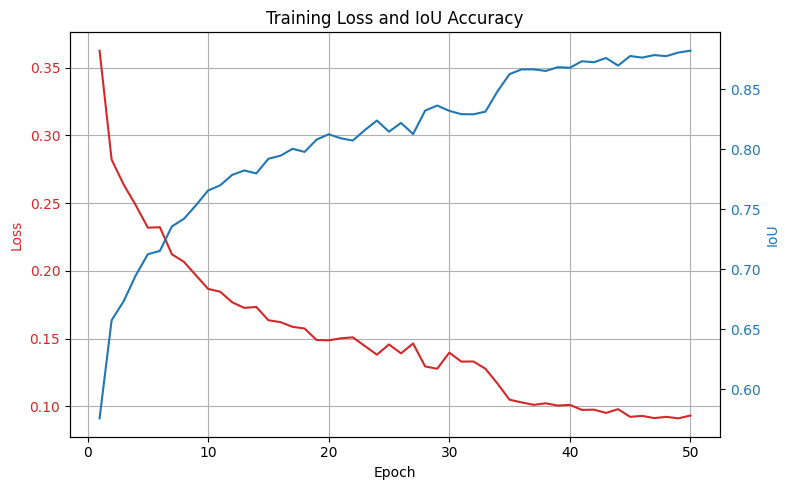

In [ ]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(8, 5))

fig, ax1 = plt.subplots(figsize=(8,5))

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, train_losses, color=color,  label='Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('IoU', color=color)
ax2.plot(epochs, train_ious, color=color,  label='IoU')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Training Loss and IoU Accuracy")
fig.tight_layout()
plt.show()

In [ ]:
#Save the training metrics
import pickle
with open("unet_results.pkl", "wb") as f:
    pickle.dump({
        "epochs": epochs,
        "train_losses": train_losses,
        "train_accuracies": train_ious
    }, f)

In [12]:
torch.save(model.state_dict(), "unet_final_50_epochs.pth")
